# Libraries

In [1]:
!pip install open-clip-torch
!pip install pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [2]:
import torch
import open_clip
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from open_clip import tokenize
import torch
from open_clip import create_model_and_transforms, tokenize
import pandas as pd
import ast
import pinecone
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load **CLIP** Model

In [3]:
# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the most powerful CLIP model available (ViT-g is strong)
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="ViT-g-14",
    pretrained="laion2b_s34b_b88k",
    device=device
)
tokenizer = open_clip.get_tokenizer("ViT-g-14")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/5.47G [00:00<?, ?B/s]

# Generate Embeddings

In [ ]:

# Function to embed texts
def embed_texts(texts, batch_size=128):
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding Batches"):
        batch = texts[i:i + batch_size]
        tokens = tokenizer(batch).to(device)
        with torch.no_grad():
            text_features = model.encode_text(tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        embeddings.append(text_features.cpu())

    return torch.cat(embeddings, dim=0)

# Load your dataset
df = pd.read_csv("dataset.csv")

# Ensure text column exists
if "text" not in df.columns:
    raise ValueError("No 'text' column found in dataset.csv")

# Clean and convert text to string
texts = df["text"].astype(str).tolist()

# Generate embeddings
text_embeddings = embed_texts(texts, batch_size=128)

# Add embedding to DataFrame (convert to list of floats)
df["embedding"] = [emb.tolist() for emb in text_embeddings]

# Save to new CSV
df.to_csv("dataset_with_embeddings.csv", index=False)
print("Saved embeddings to dataset_with_embeddings.csv")


Embedding Batches: 100%|██████████| 391/391 [12:36<00:00,  1.93s/it]


Saved embeddings to dataset_with_embeddings.csv


# Connect to PineCone(Vector-Based DB)

In [18]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="pcsk_2PDLCd_Tiqd1mZzYUAZYCbSQxRcyDu4dUD98yGQ6H4iC6SkrENxAUZb68H7fBXGH54d8EB")

## Create Index

In [19]:
index_name = "comments"

In [ ]:
pc.create_index(
    name=index_name,
    dimension=1024, # embedding dimensions
    metric="cosine", # Cosine Similarity
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

{
    "name": "comments",
    "metric": "cosine",
    "host": "comments-1u5dgl9.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1024,
    "deletion_protection": "disabled",
    "tags": null
}

## Load Embeddings

In [ ]:
import json

# Faster parsing using json
df = pd.read_csv("final_dataset_without_em.csv")
df["embedding"] = df["embedding"].apply(json.loads)


In [ ]:
index = pc.Index("comments")

## UPSERT Data

In [ ]:
# Replace "comments" with your actual index name
# Step 3: Prepare and upsert data in batches
batch_size = 200
items = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    vector_id = str(i)  # Use the row index as the ID
    vector_values = row["embedding"]
    metadata = {"category": row["label"]}
    items.append((vector_id, vector_values, metadata))

    if len(items) == batch_size:
        index.upsert(vectors=items)
        items = []

# Upsert any remaining items
if items:
    index.upsert(vectors=items)

print("Upsert complete.")


# Generate Image Embedding(query)

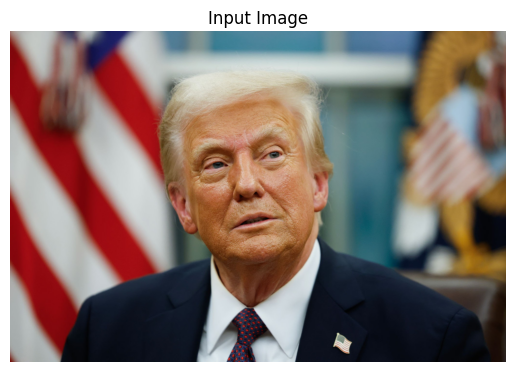

tensor([ 0.0384,  0.0263, -0.0060,  ..., -0.0339, -0.0472,  0.0153])


In [ ]:
# Function to get image embedding
def get_image_embedding(image_path):

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    # Show the image
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()
    image_tensor = preprocess(image).unsqueeze(0).to(device)


    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)  # Normalize

    return image_features.squeeze(0).cpu()

# Example usage
embedding = get_image_embedding("image.jpg")
print(embedding)  # Should be (1024,)


# Perform ANN Search(image --> text)

In [ ]:
from pinecone.grpc import PineconeGRPC as Pinecone


search_result= index.query(
    vector=embedding.cpu().numpy().tolist(),
    top_k=50,
    include_metadata=True,
    include_values=False
)

In [ ]:
print(search_result)

{'matches': [{'id': '43975',
              'metadata': {'category': 'r/politics'},
              'score': 0.286726981,
              'values': []},
             {'id': '26677',
              'metadata': {'category': 'r/worldnews'},
              'score': 0.286696464,
              'values': []},
             {'id': '25566',
              'metadata': {'category': 'r/europe'},
              'score': 0.279911101,
              'values': []},
             {'id': '17540',
              'metadata': {'category': 'r/europe'},
              'score': 0.279630035,
              'values': []},
             {'id': '24673',
              'metadata': {'category': 'r/politics'},
              'score': 0.279249191,
              'values': []},
             {'id': '49464',
              'metadata': {'category': 'r/europe'},
              'score': 0.277586699,
              'values': []},
             {'id': '21882',
              'metadata': {'category': 'r/politics'},
              'score': 0.273794591

In [ ]:
import json

# Faster parsing using json
df = pd.read_csv("dataset_labeled.csv")


In [ ]:
# Step 3: Extract the IDs from the search result
matched_ids = [match['id'] for match in search_result['matches']]

# Step 4: Filter your dataset using the matched IDs
df['id'] = df.index.astype(str)  # Assuming 'id' corresponds to the row index
matched_texts = df[df['id'].isin(matched_ids)]
matched_texts.to_csv('temp.csv', index=False)
# Step 5: Print the related text based on IDs
for _, row in matched_texts.iterrows():
    print(f"ID: {row['id']}\nCategory: {row['label']}\nText: {row['text']}\nSentiment: {row['predicted_label']}\n{'-'*60}")



ID: 3124
Category: r/europe
Text: ribbentrump
Sentiment: negative
------------------------------------------------------------
ID: 5947
Category: r/politics
Text: Trump has always believed he is above the law.  He is profoundly damaged.
Sentiment: negative
------------------------------------------------------------
ID: 8744
Category: r/europe
Text: Trump does not like to pay debts and fulfill his obligations.
Sentiment: negative
------------------------------------------------------------
ID: 9367
Category: r/politics
Text: But what if Trump runs for a 3rd time?
Sentiment: neutral
------------------------------------------------------------
ID: 11053
Category: r/worldnews
Text: Huh? Trump himself is a walking vessel of disinformation
Sentiment: negative
------------------------------------------------------------
ID: 12946
Category: r/politics
Text: Historical revisionism is a priority for Trump. It is absolutely vital that he be thwarted.
Sentiment: negative
-------------------------

# WordCloud of the Retrieved Comments

In [ ]:
import spacy
import pandas as pd

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Define a function to tokenize and preprocess text
def preprocess_text_spacy(text):
    # Tokenize the text
    doc = nlp(text)

    # Remove stopwords and non-alphabetic words, and return tokens
    tokens = [token.text.lower() for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

# Example: Assuming df['text'] is your column with comments
df_temp = pd.read_csv("temp.csv")

# Apply preprocessing to the 'text' column
df_temp['cleaned_text'] = df_temp['text'].apply(preprocess_text_spacy)

# Now you can use this cleaned text for further processing like word cloud


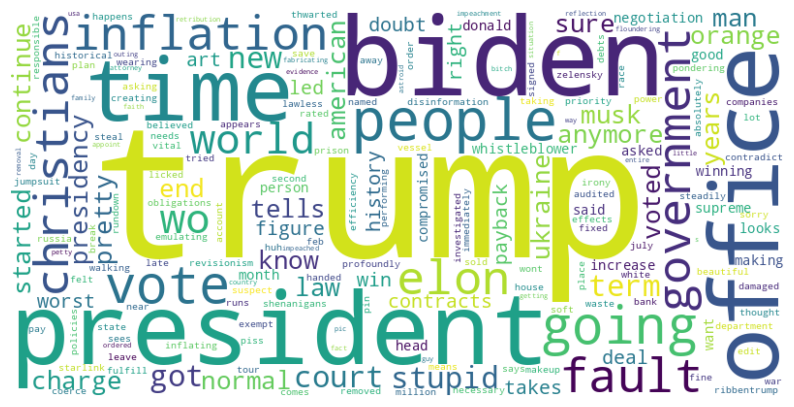

Top 20 most used words:
 1. trump: 1.000
 2. biden: 0.161
 3. president: 0.143
 4. office: 0.125
 5. time: 0.107
 6. people: 0.107
 7. vote: 0.089
 8. going: 0.089
 9. government: 0.071
10. elon: 0.071
11. christians: 0.071
12. inflation: 0.071
13. fault: 0.071
14. world: 0.054
15. wo: 0.054
16. stupid: 0.054
17. new: 0.054
18. got: 0.054
19. term: 0.054
20. court: 0.054


In [ ]:


# Step 3: Combine all the comments into one string
all_text = ' '.join(df_temp['cleaned_text'])

# Step 4: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Step 5: Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for better visualization
plt.show()
# Get top 20 words
top_words = sorted(wordcloud.words_.items(), key=lambda x: x[1], reverse=True)[:20]

# Display them
print("Top 20 most used words:")
for i, (word, freq) in enumerate(top_words, 1):
    print(f"{i:2d}. {word}: {freq:.3f}")

# Sentiment Distribution over Retrieved Data

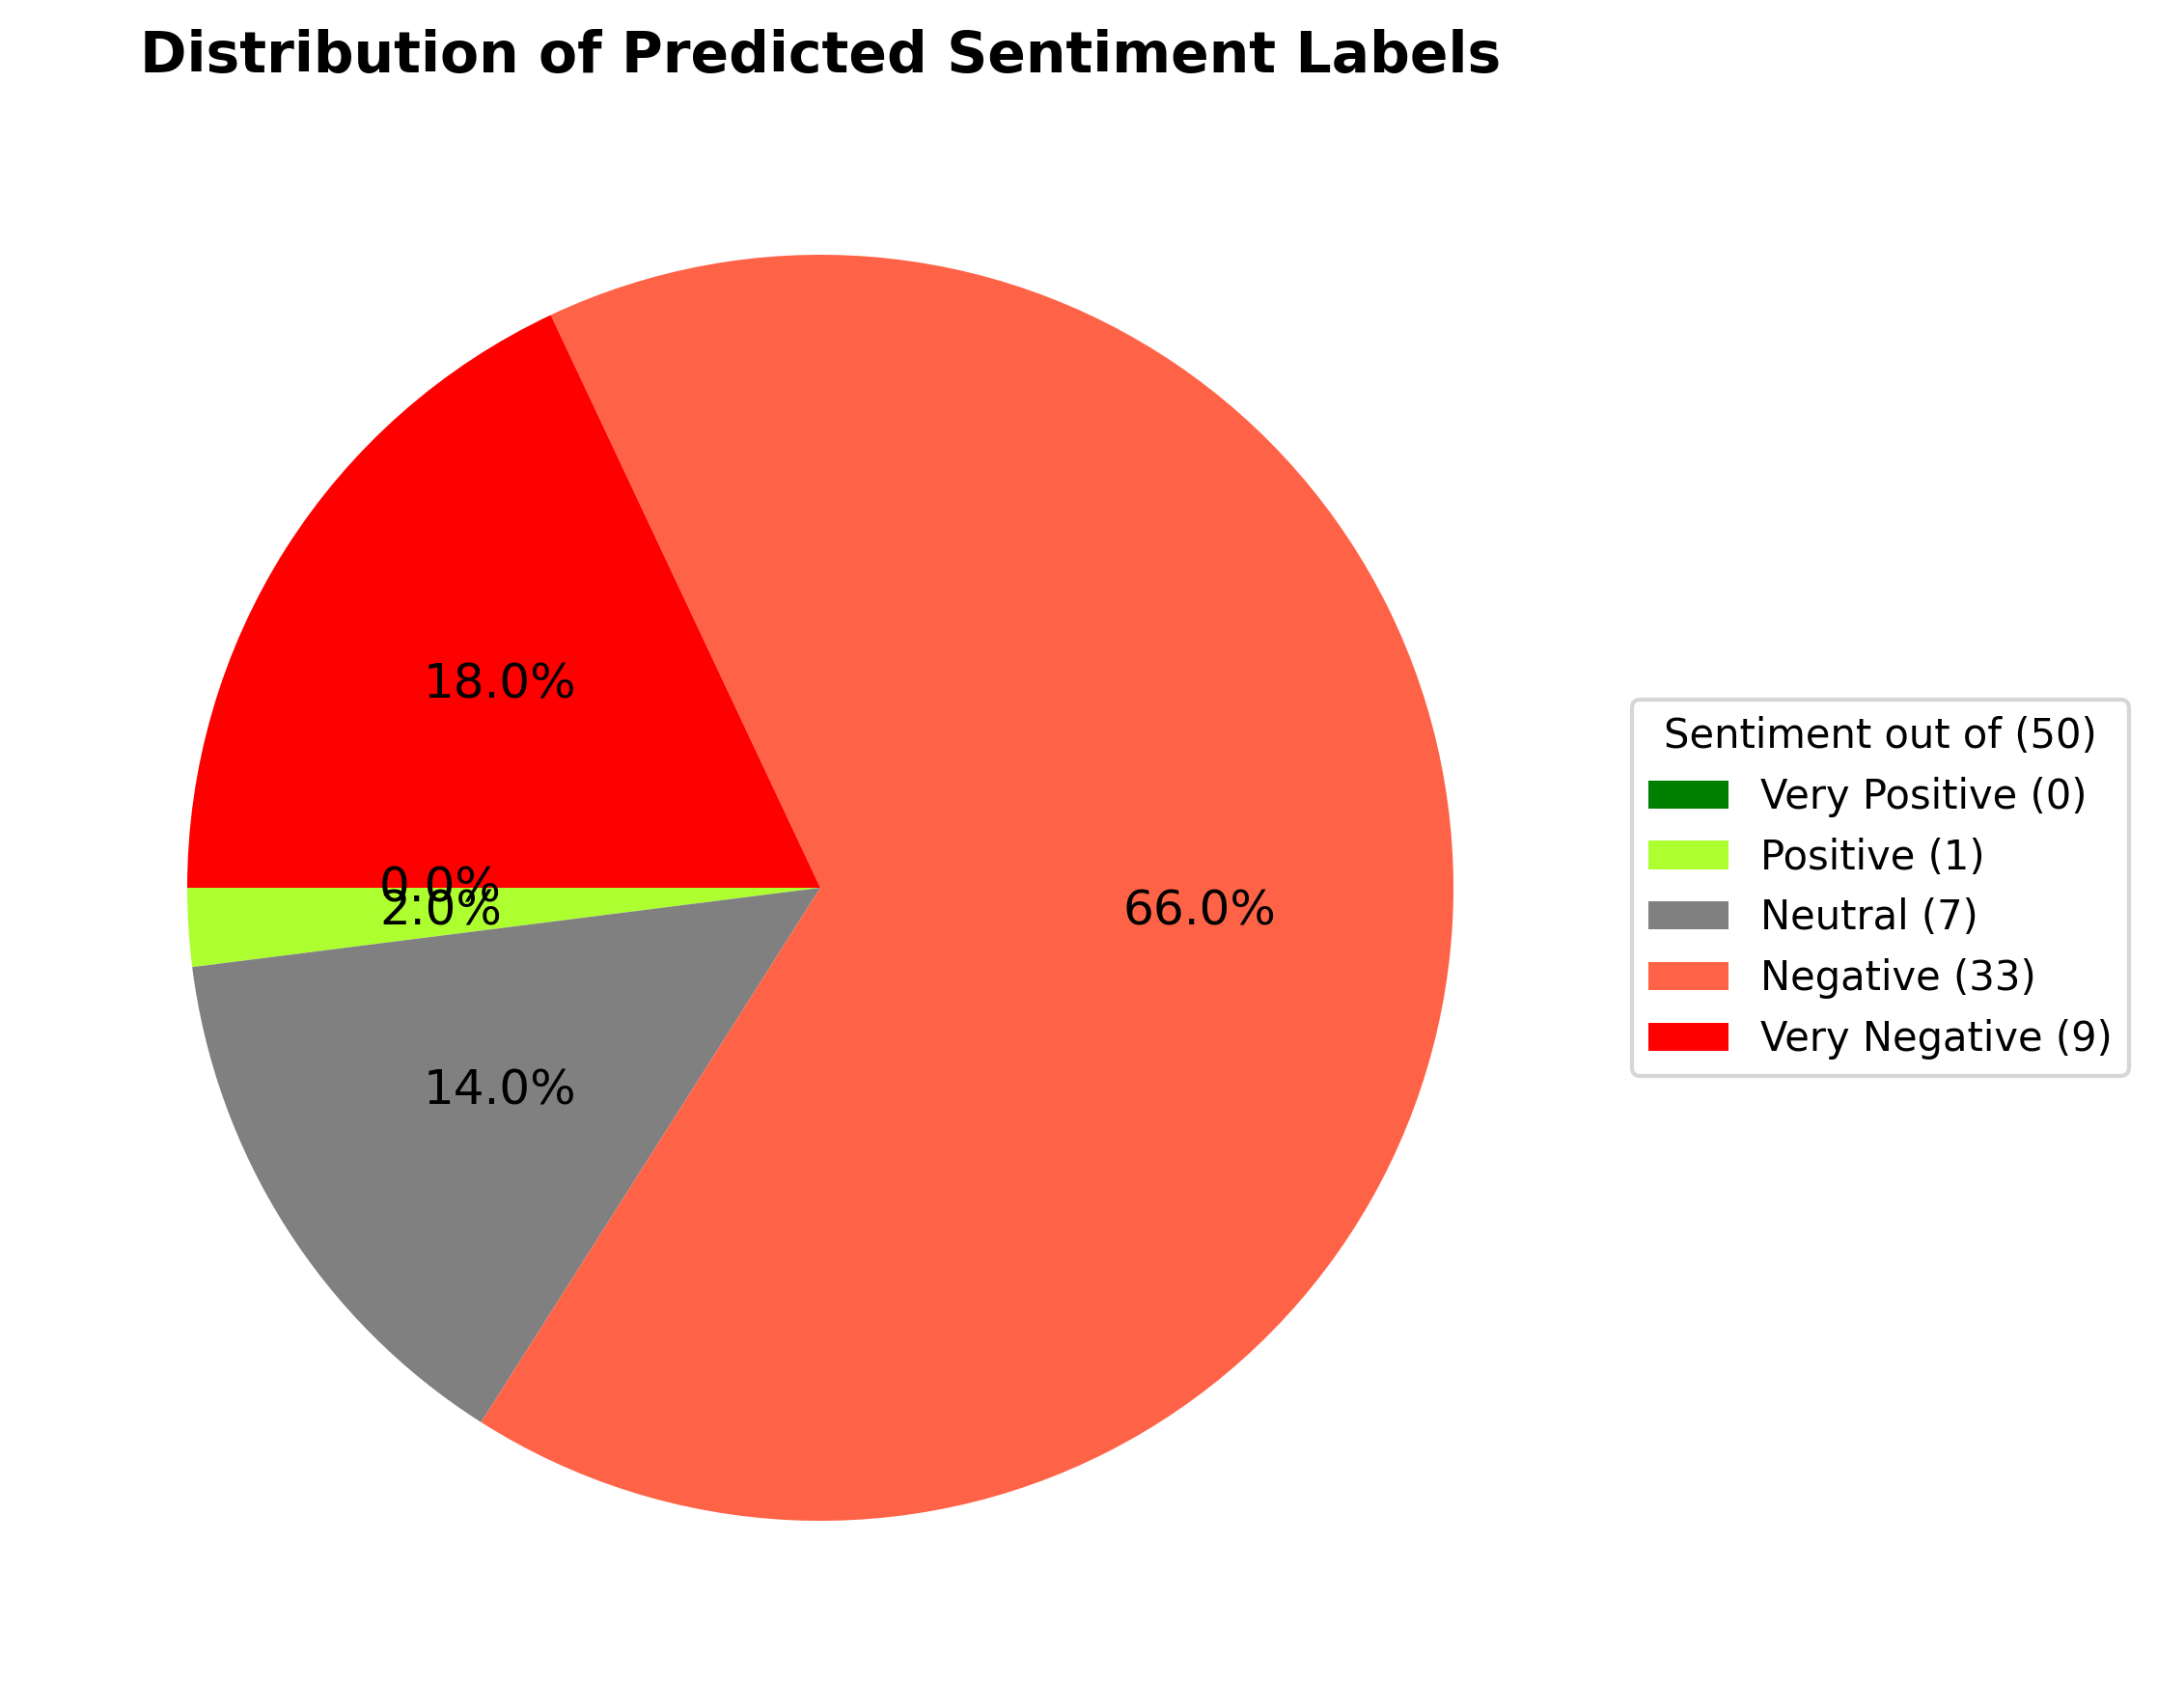

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('temp.csv')

# Step 2: Normalize labels (lowercase and strip whitespace)
df['predicted_label'] = df['predicted_label'].str.strip().str.lower()

# Step 3: Map to standard symbols
label_map = {
    'positive': '+',
    'neutral': '=',
    'negative': '-',
    'very positive': '++',
    'very negative': '--'
}
df['predicted_label'] = df['predicted_label'].map(label_map)

# Step 4: Count the occurrences of each label
labels = ['++', '+', '=', '-', '--']
colors = ['green', 'greenyellow', 'gray', 'tomato', 'red']
label_names = {
    '++': 'Very Positive',
    '+': 'Positive',
    '=': 'Neutral',
    '-': 'Negative',
    '--': 'Very Negative'
}
label_counts = df['predicted_label'].value_counts()
counts = [label_counts.get(label, 0) for label in labels]

# Step 5: Plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
wedges, texts, autotexts = ax.pie(
    counts,
    colors=colors,
    startangle=180,
    autopct='%1.1f%%',
    textprops=dict(color="black", fontsize=12)
)

# Add legend outside
legend_labels = [f"{label_names[label]} ({counts[i]})" for i, label in enumerate(labels)]
ax.legend(wedges, legend_labels, title=f"Sentiment out of ({len(df)})", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

# Title and layout
plt.title('Distribution of Predicted Sentiment Labels', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# Text-->Text SEMANTICAL Search

### Query Vector

In [44]:
text = "who is the best basketball player?"

tokens = tokenizer(text).to(device)
text_features = model.encode_text(tokens)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)
query_vector = text_features.cpu().tolist()[0]
print(query_vector)
print(len(query_vector))

[-0.02518942765891552, -0.01616876758635044, -0.04190549626946449, -0.011700890026986599, -0.015415623784065247, -0.0011907441075891256, -0.004637585487216711, 0.01617235690355301, 0.015374790877103806, 0.11107168346643448, -0.010210087522864342, -0.0052332887426018715, -0.01182769238948822, -0.007516289129853249, -0.025799432769417763, 0.042956411838531494, 0.008193980902433395, 0.04672557860612869, 0.021488938480615616, 0.020941657945513725, -0.025580743327736855, -0.04758124053478241, 0.0404515415430069, 0.007423620671033859, -0.0012421171413734555, 0.012956978753209114, 0.0242204200476408, 0.009194419719278812, 0.0011828804854303598, -0.010868332348763943, 0.011116011999547482, -0.007175033446401358, 0.004612872377038002, 0.09080129116773605, 0.004986849147826433, -0.02110791951417923, 0.001834099879488349, -0.01988169364631176, 0.01404053159058094, -0.02228555828332901, 0.0022913424763828516, -0.0461566336452961, -0.0018053611274808645, -0.025002535432577133, -0.018580833449959755

### ANN Simple Search

In [45]:
from pinecone.grpc import PineconeGRPC as Pinecone
index = pc.Index("comments")

search_result= index.query(
    vector=query_vector,
    top_k=50,
    include_metadata=True,
    include_values=False
)

In [46]:
print(search_result)

{'matches': [{'id': '47291',
              'metadata': {'category': 'r/nba'},
              'score': 0.706695557,
              'values': []},
             {'id': '6729',
              'metadata': {'category': 'r/nba'},
              'score': 0.687277853,
              'values': []},
             {'id': '28697',
              'metadata': {'category': 'r/nba'},
              'score': 0.654146135,
              'values': []},
             {'id': '46513',
              'metadata': {'category': 'r/nba'},
              'score': 0.648203552,
              'values': []},
             {'id': '42773',
              'metadata': {'category': 'r/nba'},
              'score': 0.647092402,
              'values': []},
             {'id': '2345',
              'metadata': {'category': 'r/nba'},
              'score': 0.641441345,
              'values': []},
             {'id': '29854',
              'metadata': {'category': 'r/nba'},
              'score': 0.640152574,
              'values': []},
 

In [47]:
import json

# Faster parsing using json
df = pd.read_csv("dataset_labeled.csv")


In [48]:
# Step 3: Extract the IDs from the search result (in the correct order)
matched_ids = [match['id'] for match in search_result['matches']]

# Step 4: Filter and reorder your dataset using the matched IDs
df['id'] = df.index.astype(str)  # Assuming 'id' corresponds to index as string
matched_texts = df[df['id'].isin(matched_ids)].copy()

# Reorder according to matched_ids
matched_texts = matched_texts.set_index('id').loc[matched_ids].reset_index()

# Step 5: Save and print
matched_texts.to_csv('temp.csv', index=False)

for _, row in matched_texts.iterrows():
    print(f"ID: {row['id']}\nCategory: {row['label']}\nText: {row['text']}\nSentiment: {row['predicted_label']}\n{'-'*60}")


ID: 47291
Category: r/nba
Text: So does anyone actually like basketball?
Sentiment: neutral
------------------------------------------------------------
ID: 6729
Category: r/nba
Text: How do you not love this basketball player.
Sentiment: positive
------------------------------------------------------------
ID: 28697
Category: r/nba
Text: Best fucking basketball player on the planet. One of the greatest offensive players to ever play the game
Sentiment: very positive
------------------------------------------------------------
ID: 46513
Category: r/nba
Text: You don't know basketball
Sentiment: negative
------------------------------------------------------------
ID: 42773
Category: r/nba
Text: Why I love basketball? Because it's a beautiful sport that individual athleticism and skill can be showcased in a competitive way. It's fun as hell and watching single athletes be able to carry a team sport the way basketball can is impressive.

And in the current era talent is spread out and ev

## RE-RANKER

### Let's use a RE-RANKER TO MAKE THE SEARCH ENGINE BETTER

In [42]:
!pip install sentence-transformers


In [49]:
from sentence_transformers import CrossEncoder
import pandas as pd

# Sample query and retrieved docs (replace with your actual data)
query = "who is the best basketball player?"
retrieved_docs = pd.read_csv("temp.csv")['text']




In [51]:
retrieved_docs.head(10)

,text
0,So does anyone actually like basketball?
1,How do you not love this basketball player.
2,Best fucking basketball player on the planet. ...
3,You don't know basketball
4,Why I love basketball? Because it's a beautifu...
5,Star players in the dunk contest hype???
6,what do you think the nba should change then?
7,No one needs basketball either
8,He played for a team that won a basketball gam...
9,try playing fantasy basketball. focuses your a...


In [54]:
# Load a cross-encoder model for re-ranking
# You can use models like: 'cross-encoder/ms-marco-MiniLM-L-6-v2', 'cross-encoder/ms-marco-MiniLM-L-12-v2'
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [56]:
# Prepare query-document pairs
query_doc_pairs = [(query, doc) for doc in retrieved_docs]

# Get relevance scores
scores = reranker.predict(query_doc_pairs)

# Combine docs and scores, then sort
ranked_results = sorted(zip(retrieved_docs, scores), key=lambda x: x[1], reverse=True)

# Display ranked results
print("Re-ranked results:")
for rank, (doc, score) in enumerate(ranked_results, 1):
    print(f"{rank:2d}. (Score: {score:.4f}) {doc}")


Re-ranked results:
 1. (Score: 5.2890) Best fucking basketball player on the planet. One of the greatest offensive players to ever play the game
 2. (Score: 2.1444) some sort of mental gymnastics to think the best players in the best league competitions against each other isn’t “real basketball”.
 3. (Score: 1.8799) Basketball is so fucking stupid. What is the defender supposed to do? People make it seem like when guys dunk the ball they are the best players on the earth
 4. (Score: 1.2007) If the MVP went to the best player LeBron would have at least 6 by now
 5. (Score: -1.8706) They need 3 more of him. Fuck the nba just get the best dunkers in the world. I dont think anyone will care if its nba players.
 6. (Score: -3.5924) NBA players are also asked to have a lot more talent on the court, without question the average NBA player today is a big bump over the average guy in the NBA 15 years ago.
 7. (Score: -3.7984) He played for a team that won a basketball game that’s doing somethin

## SUMMARIZER

In [58]:
from transformers import pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")



Device set to use cuda:0
Your max_length is set to 142, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


In [61]:
text = """
Aspirin is a commonly used drug that helps reduce pain, inflammation, and fever.
It is often prescribed to people with heart conditions to prevent strokes or heart attacks,
because it helps thin the blood and prevent clot formation. However, aspirin also has side effects.
These can include gastrointestinal bleeding, stomach ulcers, and allergic reactions.
Long-term use or high doses can increase these risks significantly.
Doctors usually weigh the benefits and risks before recommending it.
"""

# Run the summarizer
summary = summarizer(text, max_length=100, min_length=30, do_sample=False)

# Print the result
print("🔍 Summary:")
print(summary[0]['summary_text'])

🔍 Summary:
Aspirin is a commonly used drug that helps reduce pain, inflammation, and fever. It is often prescribed to people with heart conditions to prevent strokes or heart attacks. However, aspirin also has side effects. These can include gastrointestinal bleeding and stomach ulcers.


In [84]:
overall_text = [result[0] for result in ranked_results[:10]]

In [85]:
text = ""
for t in overall_text:
  text += t

In [88]:
# Run the summarizer
summary = summarizer(text, max_length=200, min_length=30, do_sample=False)

# Print the result
print("🔍 Summary:")
print(summary[0]['summary_text'])

🔍 Summary:
Basketball is so stupid. What is the defender supposed to do? People make it seem like when guys dunk the ball they are the best players on the earth. If the MVP went to the best player LeBron would have at least 6 by now.
